In [ ]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import sys
import os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import importlib

import opensim as osim
import util as util
import metabolics as meta

sys.path.append('.')
print(f"OpenSim version: {osim.GetVersion()}")

OpenSim version: 4.5.2-2025-04-07-2c9fc5bc9


## 1. Project Setup

In [2]:
# %% Define Project Paths
BASE_DIR = Path("C:/Users/natha/Desktop/UCLA/_Grad/2025-2026/FALL 2025/MAE 263E/MAE 263E Final Project/MAE 263E Project Code")

# Create project structure
project_dirs = util.create_project_structure(BASE_DIR)

# Define input files
GENERIC_MODEL = BASE_DIR / "data" / "gait2392_simbody.osim"
STATIC_TRIAL = BASE_DIR / "data" / "subject01_static.trc"
WALKING_TRIAL = BASE_DIR / "data" / "subject01_walk.trc"
GRF_FILE = BASE_DIR / "data" / "subject01_walk_grf.mot"
GRF_XML = BASE_DIR / "data" / "external_loads.xml"

# Define setup files (if using XML)
SCALE_SETUP = BASE_DIR / "data" /"subject01_Setup_Scale.xml"
IK_SETUP = BASE_DIR / "data" / "subject01_Setup_IK.xml"
ID_SETUP = BASE_DIR / "data" / "subject01_Setup_ID.xml"
CMC_SETUP = BASE_DIR / "data" /  "subject01_Setup_CMC.xml"
RRA_SETUP = BASE_DIR / "data" /  "subject01_Setup_RRA.xml"

# Subject information
SUBJECT_MASS = 75.0  # kg

print("✓ Project paths configured")


✓ Project structure created at: C:\Users\natha\Desktop\UCLA\_Grad\2025-2026\FALL 2025\MAE 263E\MAE 263E Final Project\MAE 263E Project Code
✓ Project paths configured


## 2. Model Scaling
Scale the generic model to match subject anthropometry using static trial

In [27]:
scale_tool = osim.ScaleTool(str(SCALE_SETUP))
scale_tool.run()

True

## 3. Inverse Kinematics
Compute joint angles from marker trajectories

In [28]:
ik_tool = osim.InverseKinematicsTool(str(IK_SETUP))
ik_tool.run()

True

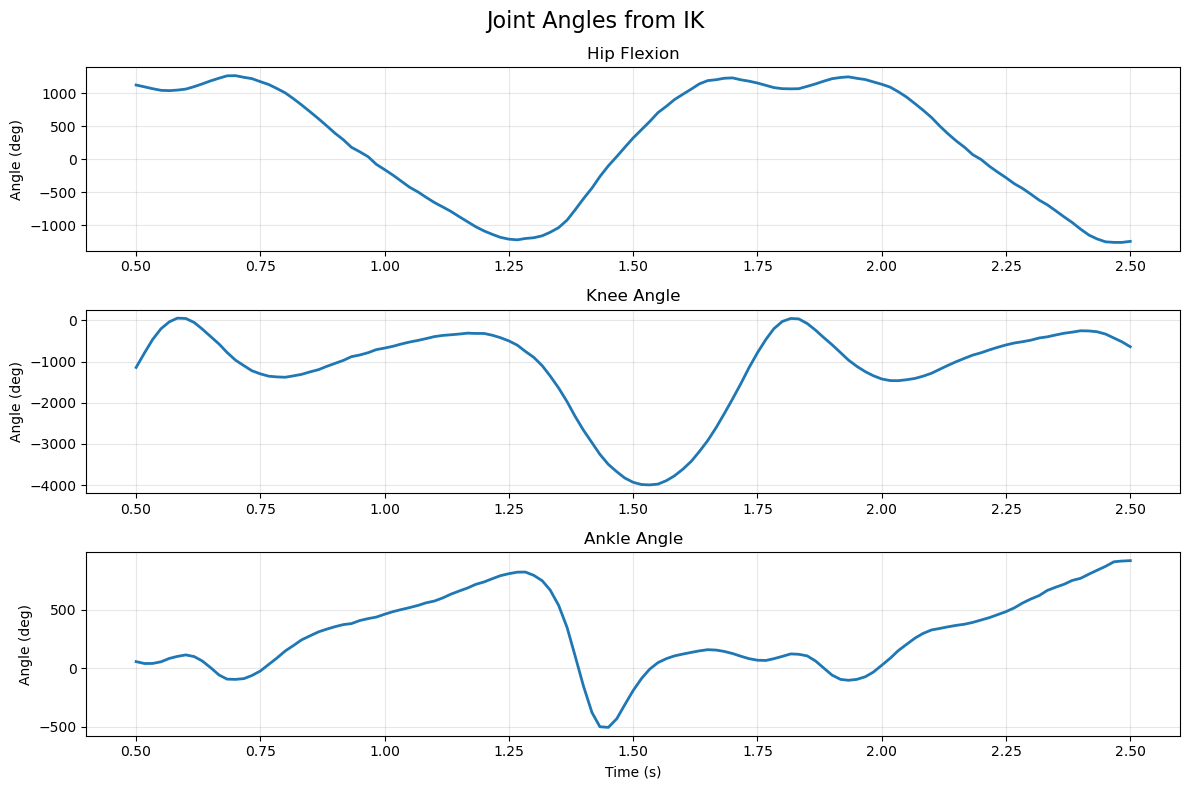

In [29]:
ik_results = project_dirs['data']['results']['ik'] + "/subject01_walk1_ik.mot"
ik_data = util.load_storage_to_dict(ik_results)

# Plot hip, knee, and ankle joint angles
fig, axes = plt.subplots(3, 1, figsize=(12, 8))
fig.suptitle('Joint Angles from IK', fontsize=16)

joints_to_plot = [
    ('hip_flexion_r', 'Hip Flexion'),
    ('knee_angle_r', 'Knee Angle'),
    ('ankle_angle_r', 'Ankle Angle')
]

for ax, (joint, title) in zip(axes, joints_to_plot):
    if joint in ik_data:
        ax.plot(ik_data['time'], np.rad2deg(ik_data[joint]), linewidth=2)
        ax.set_ylabel('Angle (deg)')
        ax.set_title(title)
        ax.grid(True, alpha=0.3)

axes[-1].set_xlabel('Time (s)')
plt.tight_layout()
plt.show()

## 4. Inverse Dynamics
Calculate joint moments from kinematics and ground reaction forces

In [ ]:
id_tool = osim.InverseDynamicsTool(str(ID_SETUP))    
print("Results directory:", id_tool.getResultsDir())
print("Model file:", id_tool.getModelFileName())
print("ground forces file:", id_tool.getOutputGenForceFileName ()) 
print("Coordinate file:", id_tool.getCoordinatesFileName())

id_tool.setExternalLoadsFileName("subject01_walk1_grf.xml")
id_tool.setCoordinatesFileName("results/ik/subject01_walk1_ik.mot")

Results directory: results/id
Model file: data/results/scaling/subject01_simbody.osim
ground forces file: subject01_walk_ID.sto
Coordinate file: data/results/ik/subject01_walk_IK.mot


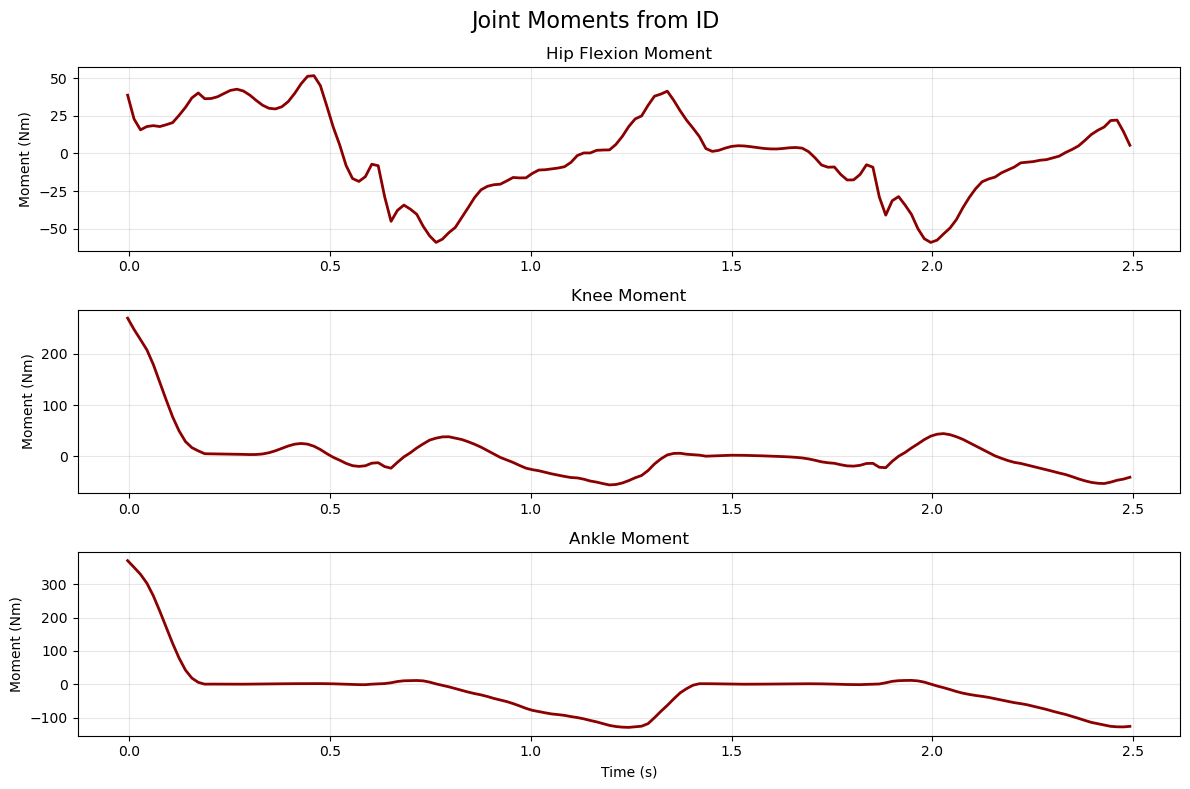

In [10]:
id_tool.run()

# %% Visualize ID Results
# Load and plot joint moments
id_results = project_dirs['data']['results']['id'] + "/subject01_walk_ID.sto"
id_data = util.load_storage_to_dict(id_results)

fig, axes = plt.subplots(3, 1, figsize=(12, 8))
fig.suptitle('Joint Moments from ID', fontsize=16)

moments_to_plot = [
    ('hip_flexion_r_moment', 'Hip Flexion Moment'),
    ('knee_angle_r_moment', 'Knee Moment'),
    ('ankle_angle_r_moment', 'Ankle Moment')
]

for ax, (moment, title) in zip(axes, moments_to_plot):
    if moment in id_data:
        ax.plot(id_data['time'], id_data[moment], linewidth=2, color='darkred')
        ax.set_ylabel('Moment (Nm)')
        ax.set_title(title)
        ax.grid(True, alpha=0.3)

axes[-1].set_xlabel('Time (s)')
plt.tight_layout()
plt.show()

# 5. RRA

In [13]:
RRA_tool = osim.RRATool(str(RRA_SETUP))   
print("Desired Kinematics File Name:", RRA_tool.getDesiredKinematicsFileName()) 
print("Task Set File Name:", RRA_tool.getTaskSetFileName())
print("Constraints File Name:", RRA_tool.getConstraintsFileName())
print("External Loads File Name:", RRA_tool.getExternalLoadsFileName())

Desired Kinematics File Name: results/ik/subject01_walk1_ik.mot
Task Set File Name: gait2392_RRA_Tasks.xml
Constraints File Name: gait2392_RRA_ControlConstraints.xml
External Loads File Name: subject01_walk1_grf.xml


In [14]:
RRA_tool.run()

True

## 6. Computed Muscle Control (CMC)
Compute muscle activations that reproduce the desired kinematics
**Note:** CMC requires actuators and tasks XML files

In [28]:
# CMC Setup files
ACTUATORS_FILE = BASE_DIR / "data" / "gait2392_CMC_Actuators.xml"
TASKS_FILE = BASE_DIR / "data" / "gait2392_CMC_Tasks.xml"

CMC_tool = osim.CMCTool(str(CMC_SETUP))    
print("Constraints File Name:", CMC_tool.getConstraintsFileName())
print("External Loads File Name:", CMC_tool.getExternalLoadsFileName())
print("Constraints File Name:", CMC_tool.getConstraintsFileName())
print("Desired Kinematics File Name:", CMC_tool.getDesiredKinematicsFileName())

Constraints File Name: gait2392_CMC_ControlConstraints.xml
External Loads File Name: subject01_walk1_grf.xml
Constraints File Name: gait2392_CMC_ControlConstraints.xml
Desired Kinematics File Name: results/rra/subject01_walk1_RRA_Kinematics_q.sto


In [29]:
CMC_tool.run()

True

dict_keys(['time', 'glut_med1_r', 'glut_med2_r', 'glut_med3_r', 'glut_min1_r', 'glut_min2_r', 'glut_min3_r', 'semimem_r', 'semiten_r', 'bifemlh_r', 'bifemsh_r', 'sar_r', 'add_long_r', 'add_brev_r', 'add_mag1_r', 'add_mag2_r', 'add_mag3_r', 'tfl_r', 'pect_r', 'grac_r', 'glut_max1_r', 'glut_max2_r', 'glut_max3_r', 'iliacus_r', 'psoas_r', 'quad_fem_r', 'gem_r', 'peri_r', 'rect_fem_r', 'vas_med_r', 'vas_int_r', 'vas_lat_r', 'med_gas_r', 'lat_gas_r', 'soleus_r', 'tib_post_r', 'flex_dig_r', 'flex_hal_r', 'tib_ant_r', 'per_brev_r', 'per_long_r', 'per_tert_r', 'ext_dig_r', 'ext_hal_r', 'glut_med1_l', 'glut_med2_l', 'glut_med3_l', 'glut_min1_l', 'glut_min2_l', 'glut_min3_l', 'semimem_l', 'semiten_l', 'bifemlh_l', 'bifemsh_l', 'sar_l', 'add_long_l', 'add_brev_l', 'add_mag1_l', 'add_mag2_l', 'add_mag3_l', 'tfl_l', 'pect_l', 'grac_l', 'glut_max1_l', 'glut_max2_l', 'glut_max3_l', 'iliacus_l', 'psoas_l', 'quad_fem_l', 'gem_l', 'peri_l', 'rect_fem_l', 'vas_med_l', 'vas_int_l', 'vas_lat_l', 'med_gas_l

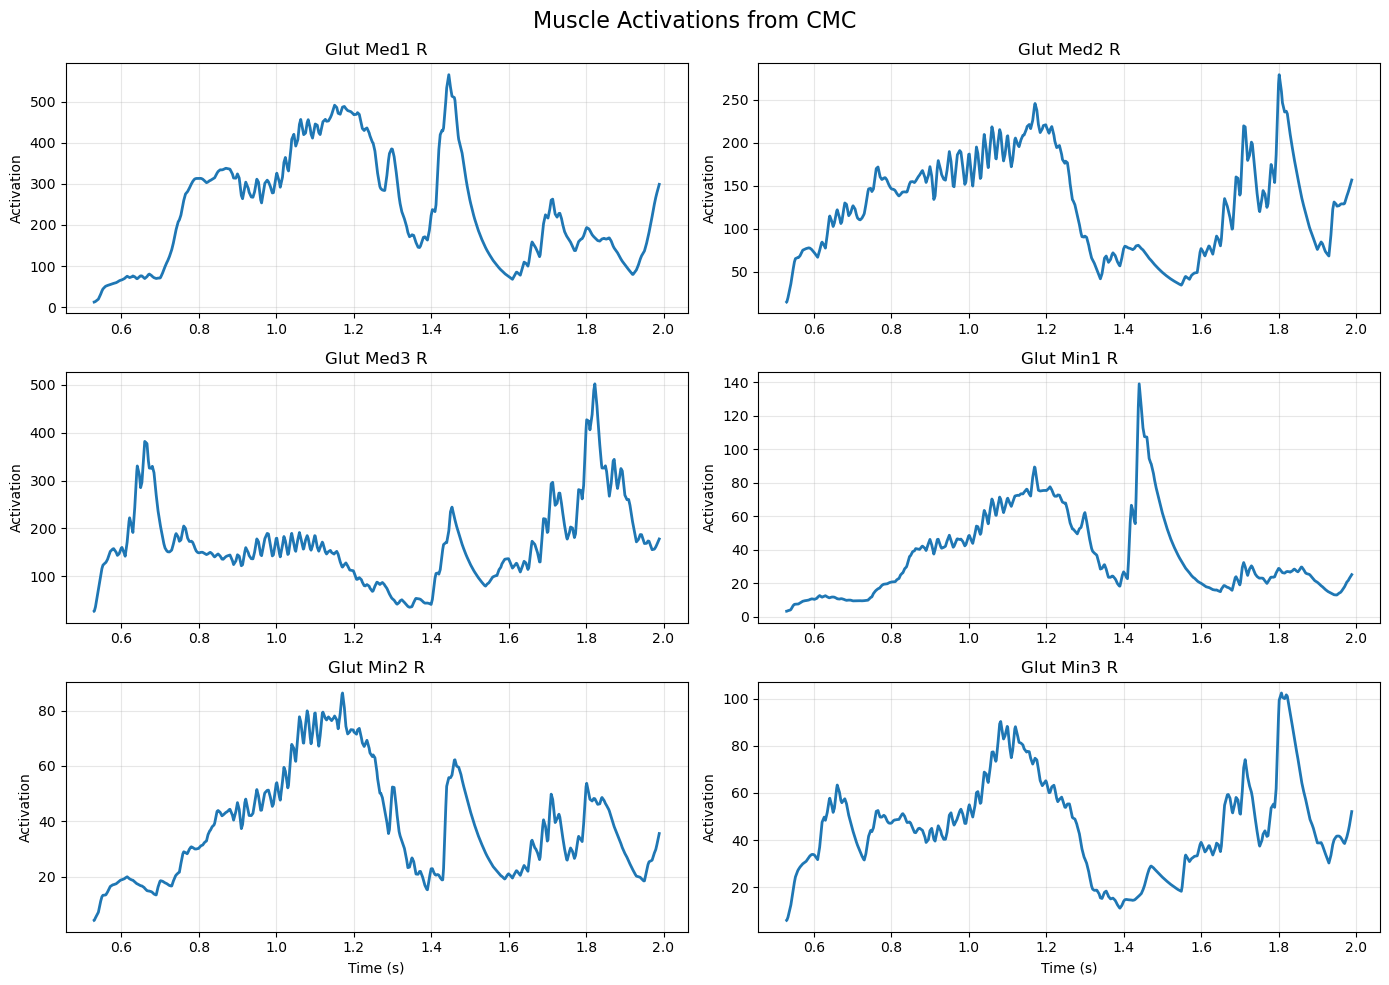

In [ ]:
# Extract CMC results
CMC_results = project_dirs['data']['results']['cmc'] + "/subject01_walk1_Actuation_force.sto"
CMC_data = util.load_storage_to_dict(CMC_results)

# %% Visualize CMC Results
# Plot muscle activations for selected muscles

print(CMC_data.keys())
# controls_data = util.load_storage_to_dict(CMC_data['controls'])

# Select some major lower limb muscles
muscles_to_plot = ['glut_med1_r', 'glut_med2_r', 'glut_med3_r', 'glut_min1_r', 
										'glut_min2_r', 'glut_min3_r']

fig, axes = plt.subplots(3, 2, figsize=(14, 10))
fig.suptitle('Muscle Activations from CMC', fontsize=16)
axes = axes.flatten()

print(CMC_data['glut_med1_r'])

for i, muscle in enumerate(muscles_to_plot):
		if muscle in muscles_to_plot:
				axes[i].plot(CMC_data['time'], CMC_data[muscle], linewidth=2)
				axes[i].set_title(muscle.replace('_', ' ').title())
				axes[i].set_ylabel('Activation')
				# axes[i].set_ylim([0, 1])
				axes[i].grid(True, alpha=0.3)
				if i >= 4:
						axes[i].set_xlabel('Time (s)')

plt.tight_layout()
plt.show()

## 7. Metabolic Analysis
Calculate metabolic cost using Umberger2010 or Bhargava2004 probes

In [44]:
# Add metabolic probes to model
model_with_probes = add_metabolic_probes(
    model_path=scaled_model,
    output_model_path=str(project_dirs['results']['metabolics'] / "model_with_probes.osim"),
    probe_type='Umberger2010'  # or 'Bhargava2004'
)

# Analyze metabolics using CMC states
if 'states' in cmc_files:
    metabolics_results = analyze_metabolics(
        model_with_probes_path=model_with_probes,
        states_file=cmc_files['states'],
        output_dir=str(project_dirs['results']['metabolics'])
    )
    
    # Calculate summary statistics
    metabolic_summary = calculate_metabolic_cost(metabolics_results)
    
    print(f"\n→ Metabolics results: {metabolics_results}\n")
else:
    print("⚠ CMC states file not found. Skipping metabolic analysis.")
    metabolic_summary = {}

# %% Visualize Metabolic Cost
if metabolics_results and os.path.exists(metabolics_results):
    met_data = load_storage_to_dict(metabolics_results)
    
    if 'whole_body_metabolics' in met_data:
        fig, ax = plt.subplots(figsize=(12, 5))
        ax.plot(met_data['time'], met_data['whole_body_metabolics'], 
                linewidth=2, color='darkgreen')
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Metabolic Power (W)')
        ax.set_title('Whole Body Metabolic Power')
        ax.grid(True, alpha=0.3)
        
        # Add mean line
        mean_power = np.mean(met_data['whole_body_metabolics'])
        ax.axhline(mean_power, color='red', linestyle='--', 
                   label=f'Mean: {mean_power:.2f} W')
        ax.legend()
        
        plt.tight_layout()
        plt.show()


NameError: name 'add_metabolic_probes' is not defined

## 8. Results Summary
Create Results Summary

In [ ]:
print("=" * 60)
print("PIPELINE COMPLETE - SUMMARY")
print("=" * 60)

results_summary = {
    'subject': {
        'mass_kg': SUBJECT_MASS,
        'trial': str(WALKING_TRIAL.stem)
    },
    'files': {
        'scaled_model': str(scaled_model),
        'ik_results': str(ik_results),
        'id_results': str(id_results),
        'cmc_output': str(cmc_output_dir),
    },
    'metabolics': metabolic_summary
}

# Save summary
summary_file = save_results_summary(
    str(project_dirs['results']['metabolics']),
    results_summary
)

# Print summary
print("\n📊 Analysis Summary:")
print(f"   Scaled Model: {Path(scaled_model).name}")
print(f"   IK Results: {Path(ik_results).name}")
print(f"   ID Results: {Path(id_results).name}")
print(f"   CMC Output: {Path(cmc_output_dir).name}")

if metabolic_summary:
    print(f"\n⚡ Metabolic Cost:")
    print(f"   Mean Power: {metabolic_summary['mean_power_W']:.2f} W")
    print(f"   Total Energy: {metabolic_summary['total_energy_J']:.2f} J")
    print(f"   Duration: {metabolic_summary['duration_s']:.2f} s")

print(f"\n✓ Results summary saved to: {summary_file}")
print("\n" + "=" * 60)